# Importing Libraries

In [2]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.2 MB/s eta 0:00:00


In [3]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score, mean_absolute_error, confusion_matrix, precision_recall_curve
from sklearn.metrics import ndcg_score, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, Flatten, Concatenate, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the existing Keras Tuner project directory if it exists

In [4]:
project_dir = 'keras_tuner_dir/tvet_course_recommender'
if os.path.exists(project_dir):
    shutil.rmtree(project_dir)

# Load data

In [6]:
!wget https://github.com/RanaHammadHassan/TVET_CRS/raw/main/Tvet_data.xlsx


--2025-05-23 19:25:46--  https://github.com/RanaHammadHassan/TVET_CRS/raw/main/Tvet_data.xlsx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RanaHammadHassan/TVET_CRS/main/Tvet_data.xlsx [following]
--2025-05-23 19:25:46--  https://raw.githubusercontent.com/RanaHammadHassan/TVET_CRS/main/Tvet_data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71854 (70K) [application/octet-stream]
Saving to: ‘Tvet_data.xlsx’

Tvet_data.xlsx      100%[===================>]  70.17K  --.-KB/s    in 0.002s  

2025-05-23 19:25:46 (32.5 MB/s) - ‘Tvet_data.xlsx’ saved [71854/71854]



In [7]:
df = pd.read_excel('Tvet_data.xlsx')

In [ ]:
df

,ProfileCode,Gender,Age,Score_E,Score_A,Score_C,Score_N,Score_O,Trade
0,36,Male,18,27,36,24,28,27,Computer Application & Office Professional
1,37,Male,21,25,36,35,23,24,Computer Application & Office Professional
2,38,Male,19,21,36,32,29,27,Computer Application & Office Professional
3,39,Male,22,26,32,31,24,21,Computer Application & Office Professional
4,40,Male,17,28,33,32,16,32,Computer Application & Office Professional
...,...,...,...,...,...,...,...,...,...
1351,7276,Male,15,19,24,22,21,23,Motorcycle Mechanic
1352,7277,Male,17,18,18,26,19,25,Motorcycle Mechanic
1353,7278,Male,17,23,19,11,18,20,Motorcycle Mechanic
1354,7279,Male,18,29,32,32,20,29,Motorcycle Mechanic


# Feature Engineering

In [8]:
print(df.head())

   ProfileCode Gender  Age  Score_E  Score_A  Score_C  Score_N  Score_O  \
0           36   Male   18       27       36       24       28       27   
1           37   Male   21       25       36       35       23       24   
2           38   Male   19       21       36       32       29       27   
3           39   Male   22       26       32       31       24       21   
4           40   Male   17       28       33       32       16       32   

                                        Trade  
0  Computer Application & Office Professional  
1  Computer Application & Office Professional  
2  Computer Application & Office Professional  
3  Computer Application & Office Professional  
4  Computer Application & Office Professional  


In [9]:
print(df.describe())

       ProfileCode          Age      Score_E      Score_A      Score_C  \
count  1356.000000  1356.000000  1356.000000  1356.000000  1356.000000   
mean   4285.227139    19.390855    21.516962    29.602507    31.682891   
std    2469.950828     3.151155     5.747877     4.996438     5.865381   
min      36.000000    14.000000     4.000000     9.000000    10.000000   
25%    1295.750000    17.000000    18.000000    27.000000    28.000000   
50%    5254.500000    19.000000    22.000000    30.000000    32.000000   
75%    5593.250000    21.000000    26.000000    33.000000    36.000000   
max    7280.000000    35.000000    39.000000    40.000000    40.000000   

           Score_N      Score_O  
count  1356.000000  1356.000000  
mean     19.140118    27.055310  
std       7.478944     5.510463  
min       0.000000     8.000000  
25%      13.000000    24.000000  
50%      19.000000    27.000000  
75%      25.000000    31.000000  
max      38.000000    40.000000  


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1356 entries, 0 to 1355
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProfileCode  1356 non-null   int64 
 1   Gender       1356 non-null   object
 2   Age          1356 non-null   int64 
 3   Score_E      1356 non-null   int64 
 4   Score_A      1356 non-null   int64 
 5   Score_C      1356 non-null   int64 
 6   Score_N      1356 non-null   int64 
 7   Score_O      1356 non-null   int64 
 8   Trade        1356 non-null   object
dtypes: int64(7), object(2)
memory usage: 95.5+ KB
None


# Data Visualization

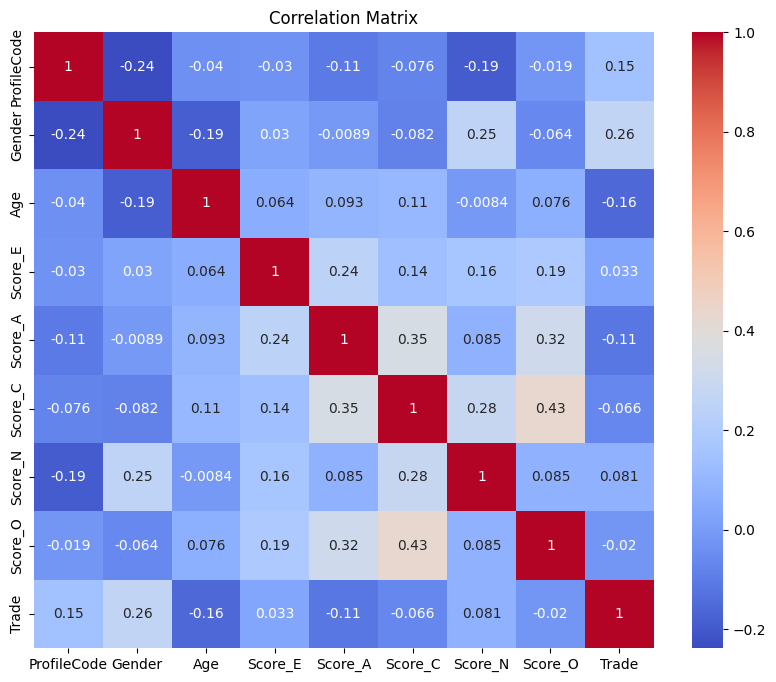

In [12]:
# Encodage des colonnes catégorielles (par exemple, Gender)
df_encoded = df.copy()

# Convert categorical columns into numeric codes
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Maintenant on peut calculer la matrice de corrélation
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Data Transformation and Normalization

In [13]:
# Encode categorical variables
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_trade = LabelEncoder()
df['Trade'] = le_trade.fit_transform(df['Trade'])

In [14]:
# Split data into features and target
X = df.drop('Trade', axis=1)
y = df['Trade']

In [15]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Preparing Data for Modeling

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
# Convert target to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

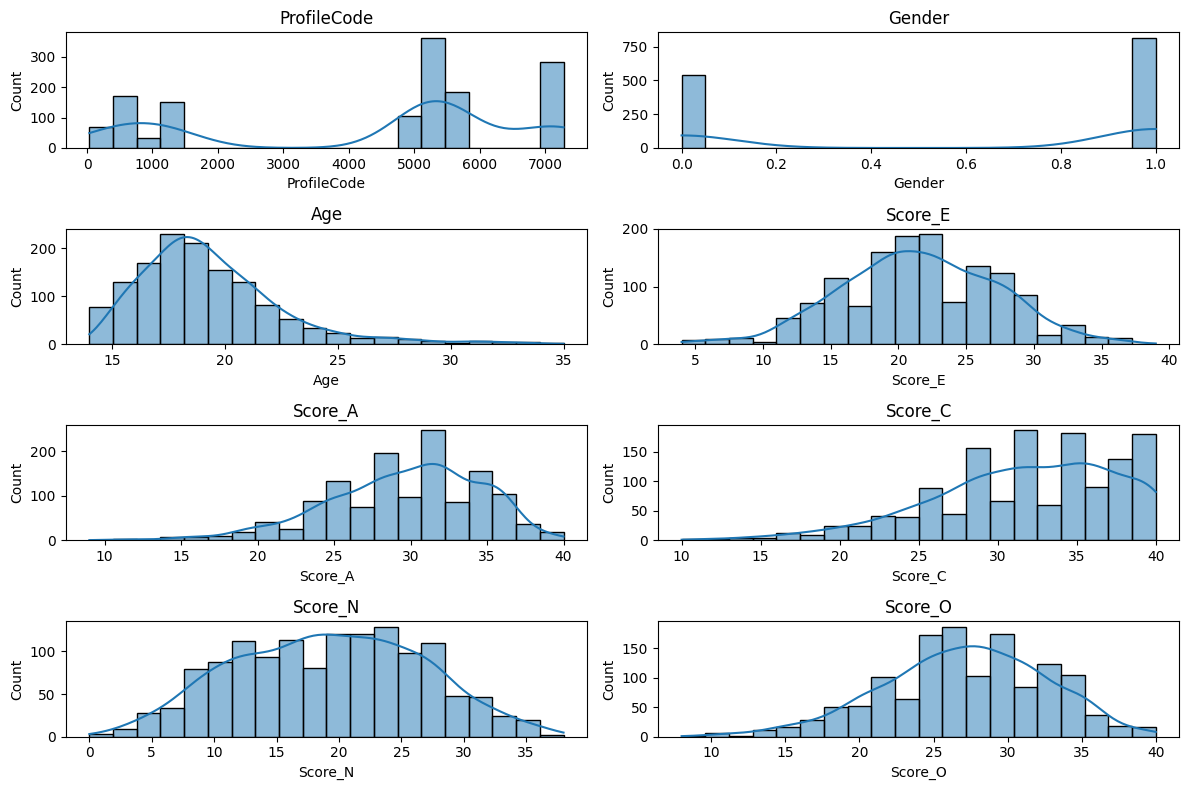

In [18]:
# Visualize the distribution of numerical features
num_features = X.shape[1]
num_rows = (num_features + 1) // 2  # Calculate the number of rows for subplots
plt.figure(figsize=(12, 8))

for i, col in enumerate(X.columns):
    plt.subplot(num_rows, 2, i+1)  # Adjusting the number of subplots dynamically
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

In [19]:
# Embedding input dimensions
gender_input_dim = len(le_gender.classes_)

# Model Building Function

In [20]:
# Build the hyperparameter tuning model
def build_model(hp):
    # Input layers
    profile_code_input = Input(shape=(1,), name='ProfileCode')
    gender_input = Input(shape=(1,), name='Gender')
    age_input = Input(shape=(1,), name='Age')
    score_e_input = Input(shape=(1,), name='Score_E')
    score_a_input = Input(shape=(1,), name='Score_A')
    score_c_input = Input(shape=(1,), name='Score_C')
    score_n_input = Input(shape=(1,), name='Score_N')
    score_o_input = Input(shape=(1,), name='Score_O')

    # Embedding layers
    gender_embedding = Embedding(input_dim=gender_input_dim, output_dim=hp.Int('gender_emb_dim', min_value=4, max_value=16, step=4))(gender_input)
    gender_embedding = Flatten()(gender_embedding)

    # Concatenate all inputs
    concatenated = Concatenate()([profile_code_input, gender_embedding, age_input, score_e_input, score_a_input, score_c_input, score_n_input, score_o_input])

    # Fully connected layers with attention
    x = Dense(units=hp.Int('units_input', min_value=128, max_value=512, step=64), activation='relu', kernel_regularizer=l2(0.001))(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_input', 0.3, 0.7, step=0.1))(x)

    for i in range(hp.Int('num_layers', 2, 5)):
        x = Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64), activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.3, 0.7, step=0.1))(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = Activation('softmax')(attention)
    x = tf.keras.layers.multiply([x, attention])

    # Output layer
    output = Dense(y_train_categorical.shape[1], activation='softmax')(x)

    model = Model(inputs=[profile_code_input, gender_input, age_input, score_e_input, score_a_input, score_c_input, score_n_input, score_o_input], outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter Tuning Setup

In [21]:
# Set up the tuner with Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='keras_tuner_dir',
    project_name='tvet_course_recommender',
    overwrite=True  # Allow overwriting the existing project
)

In [22]:
# Prepare the data for the model
train_data = {
    'ProfileCode': X_train[:, 0],
    'Gender': X_train[:, 1],
    'Age': X_train[:, 2],
    'Score_E': X_train[:, 3],
    'Score_A': X_train[:, 4],
    'Score_C': X_train[:, 5],
    'Score_N': X_train[:, 6],
    'Score_O': X_train[:, 7],
}

test_data = {
    'ProfileCode': X_test[:, 0],
    'Gender': X_test[:, 1],
    'Age': X_test[:, 2],
    'Score_E': X_test[:, 3],
    'Score_A': X_test[:, 4],
    'Score_C': X_test[:, 5],
    'Score_N': X_test[:, 6],
    'Score_O': X_test[:, 7],
}

# Searching for Best Hyperparameters

In [23]:
# Search for the best hyperparameters
tuner.search(train_data, y_train_categorical, epochs=100, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Trial 20 Complete [00h 04m 17s]
val_accuracy: 0.25806450843811035

Best val_accuracy So Far: 0.34562211235364276
Total elapsed time: 01h 10m 20s


# Get -> Save -> Load the Best Model

In [28]:
model = tf.keras.models.load_model("best_model.h5", compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
model.save('best_model.keras')


In [31]:
# Load the best model and recreate the optimizer
best_model = tf.keras.models.load_model("best_model.keras")
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Fine-tuning the Best Model

In [32]:
# Fine-tune the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [33]:
history = best_model.fit(train_data, y_train_categorical, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4469 - loss: 2.1235 - val_accuracy: 0.3226 - val_loss: 2.4975 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4971 - loss: 2.0218 - val_accuracy: 0.3134 - val_loss: 2.4800 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4830 - loss: 2.0059 - val_accuracy: 0.3226 - val_loss: 2.4602 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4753 - loss: 2.0220 - val_accuracy: 0.3088 - val_loss: 2.4436 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4761 - loss: 2.0237 - val_accuracy: 0.3180 - val_loss: 2.4171 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4828 - loss: 2.0191 - val_accuracy: 0.3364 - val_loss: 2.4479 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5018 - loss: 1.9441 - 

# Making Predictions

In [34]:
# Make predictions
y_pred_proba = best_model.predict(test_data)
y_pred = np.argmax(y_pred_proba, axis=1)

1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [35]:
# Decode the predicted and actual labels
y_test_decoded = le_trade.inverse_transform(y_test)
y_pred_decoded = le_trade.inverse_transform(y_pred)

# Evaluating the Model

In [36]:
# Function to calculate Mean Reciprocal Rank (MRR)
def mrr(y_true, y_pred_proba):
    order = np.argsort(y_pred_proba, axis=1)
    ranks = np.where(order == np.expand_dims(y_true, axis=1))[1]
    return np.mean(1.0 / (ranks + 1))

In [37]:
# Calculate MAE and NMAE
mae = mean_absolute_error(y_test, y_pred)
nmae = mae / (y.max() - y.min())

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate MRR
mrr_score = mrr(y_test, y_pred_proba)

# Calculate NDCG
ndcg = ndcg_score(to_categorical(y_test), y_pred_proba, k=5)

In [38]:
# Evaluate the model using traditional metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(to_categorical(y_test), y_pred_proba, average='weighted', multi_class='ovr')
mcc = matthews_corrcoef(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

In [39]:
# Print the evaluation metrics
print(f'Model Accuracy: {accuracy}')
print(f'Model F1 Score: {f1}')
print(f'Model Precision: {precision}')
print(f'Model Recall: {recall}')
print(f'Model ROC AUC: {roc_auc}')
print(f'Model MCC: {mcc}')
print(f'Model Cohen Kappa: {cohen_kappa}')
print(f'Model MAE: {mae}')
print(f'Model NMAE: {nmae}')
print(f'Model RMSE: {rmse}')
print(f'Model MRR: {mrr_score}')
print(f'Model NDCG: {ndcg}')

Model Accuracy: 0.3860294117647059
Model F1 Score: 0.3778613191752052
Model Precision: 0.4499078757891473
Model Recall: 0.3860294117647059
Model ROC AUC: 0.8750727043990122
Model MCC: 0.3378345993879936
Model Cohen Kappa: 0.33501200445043033
Model MAE: 3.3933823529411766
Model NMAE: 0.19961072664359863
Model RMSE: 5.238081709939241
Model MRR: 0.0645722606281646
Model NDCG: 0.6471372909233085


# Saving Results

In [40]:
# Save predictions to Excel
predictions_df = pd.DataFrame({
    'Actual': y_test_decoded,
    'Predicted': y_pred_decoded
})
predictions_df.to_excel('Model-Predictions.xlsx', index=False)

In [41]:
# Save evaluation metrics to Excel
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC', 'MCC', 'Cohen Kappa', 'MAE', 'NMAE', 'RMSE', 'MRR', 'NDCG'],
    'Score': [accuracy, f1, precision, recall, roc_auc, mcc, cohen_kappa, mae, nmae, rmse, mrr_score, ndcg]
})
metrics_df.to_excel('Evaluation-Matrix.xlsx', index=False)